In [1]:
import numpy as np
import torch
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
from pathlib import Path
from typing import List, Tuple, Dict, Any, Iterator
from generals.core.grid import Grid
from generals.core.game import Game
from generals.core.observation import Observation
from generals.core.action import Action
from agents.memory import MemoryAugmentation

pygame 2.6.1 (SDL 2.28.4, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


/root/miniconda3/envs/rl/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
data_dir = Path("data/generals_io_replays")

import pyarrow.parquet as pq
parquet_file = pq.ParquetFile(
    data_dir / "data" / "train-00000-of-00001.parquet"
)
num_row_groups = parquet_file.num_row_groups

In [4]:
grid_size = 24
max_replays = 100

In [5]:
g, i = 0, 1
row_group = parquet_file.read_row_group(g)
batch = row_group.to_pydict()
row_group.column_names, batch.keys()

(['version',
  'id',
  'mapWidth',
  'mapHeight',
  'usernames',
  'stars',
  'cities',
  'cityArmies',
  'generals',
  'mountains',
  'moves'],
 dict_keys(['version', 'id', 'mapWidth', 'mapHeight', 'usernames', 'stars', 'cities', 'cityArmies', 'generals', 'mountains', 'moves']))

In [6]:
replay = {key: batch[key][i] for key in batch}
replay

{'version': 13,
 'id': '--mLQZRuz',
 'mapWidth': 18,
 'mapHeight': 22,
 'usernames': ['Human.exe', 'lishuo'],
 'stars': [82, 73],
 'cities': [143, 242, 104, 248, 108, 201, 261, 97, 195, 109],
 'cityArmies': [49, 43, 47, 43, 48, 42, 50, 46, 40, 48],
 'generals': [65, 278],
 'mountains': [1,
  2,
  10,
  11,
  32,
  34,
  50,
  57,
  58,
  71,
  78,
  91,
  100,
  113,
  130,
  136,
  137,
  138,
  146,
  148,
  151,
  154,
  156,
  158,
  162,
  163,
  168,
  169,
  170,
  174,
  175,
  185,
  188,
  189,
  190,
  191,
  192,
  202,
  203,
  208,
  213,
  216,
  217,
  220,
  226,
  229,
  234,
  235,
  243,
  246,
  247,
  249,
  250,
  252,
  263,
  264,
  271,
  284,
  288,
  293,
  304,
  305,
  311,
  318,
  320,
  322,
  325,
  328,
  337,
  341,
  356,
  358,
  360,
  363,
  376,
  392],
 'moves': [[0, 65, 64, 0, 22],
  [0, 64, 63, 0, 23],
  [0, 63, 62, 0, 24],
  [1, 278, 279, 0, 24],
  [1, 279, 280, 0, 25],
  [0, 62, 61, 0, 25],
  [0, 61, 60, 0, 26],
  [1, 280, 262, 0, 26],
  [1

In [7]:
len(replay['moves'])

736

In [8]:
def is_valid_replay(replay: Dict) -> bool:
    num_turns = len(replay['moves'])
    if num_turns > max_turns:
        return False
    if max(replay['stars']) < min_stars:
        return False
    return True

In [9]:
min_stars = 70
max_turns = 1e8

In [10]:
import tqdm
replay_moves_lengths = []
# use tqdm for progress bar
for g in tqdm.tqdm(range(num_row_groups)):
    row_group = parquet_file.read_row_group(g)
    batch = row_group.to_pydict()
    for i in range(len(batch['moves'])):
        replay = {key: batch[key][i] for key in batch}
        if not is_valid_replay(replay):
            continue
        replay_moves_lengths.append(len(replay['moves']))

100%|██████████| 19/19 [00:30<00:00,  1.61s/it]


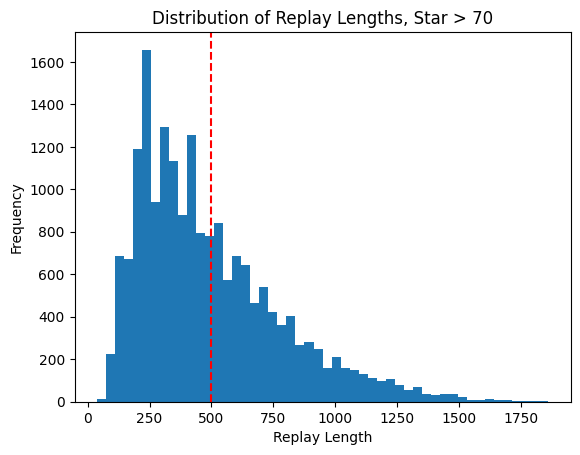

In [11]:
import matplotlib.pyplot as plt
plt.hist(replay_moves_lengths, bins=50)
# plot a dotted line at lenght = 500
plt.axvline(x=500, color='r', linestyle='--')
plt.xlabel("Replay Length")
plt.ylabel("Frequency")
plt.title(f"Distribution of Replay Lengths, Star > {min_stars}")
plt.show()


# More on Replay

In [12]:
replay

{'version': 13,
 'id': 'zzq9PpdNe',
 'mapWidth': 18,
 'mapHeight': 21,
 'usernames': ['_OLXADO_', '-zzh-'],
 'stars': [68, 83],
 'cities': [197, 167, 2, 248, 298, 153, 90, 18, 61, 246, 342],
 'cityArmies': [49, 48, 47, 45, 50, 45, 42, 46, 40, 48, 43],
 'generals': [234, 232],
 'mountains': [8,
  11,
  23,
  27,
  29,
  31,
  33,
  35,
  45,
  46,
  50,
  53,
  59,
  66,
  67,
  71,
  75,
  78,
  79,
  83,
  84,
  87,
  101,
  104,
  105,
  116,
  117,
  124,
  128,
  133,
  134,
  136,
  137,
  139,
  149,
  155,
  158,
  159,
  169,
  170,
  171,
  173,
  184,
  192,
  201,
  210,
  211,
  214,
  221,
  222,
  225,
  227,
  242,
  258,
  259,
  260,
  265,
  268,
  269,
  281,
  283,
  284,
  286,
  289,
  290,
  292,
  294,
  295,
  300,
  307,
  314,
  315,
  318,
  328,
  335,
  336,
  351,
  355,
  359,
  363,
  364,
  365],
 'moves': [[0, 234, 235, 0, 24],
  [1, 232, 231, 0, 24],
  [1, 231, 213, 0, 25],
  [0, 235, 236, 0, 25],
  [0, 236, 237, 0, 26],
  [1, 213, 195, 0, 26],
  [1,

In [ ]:
replay['moves'][:10]

[[0, 234, 235, 0, 24],
 [1, 232, 231, 0, 24],
 [1, 231, 213, 0, 25],
 [0, 235, 236, 0, 25],
 [0, 236, 237, 0, 26],
 [1, 213, 195, 0, 26],
 [1, 195, 177, 0, 27],
 [0, 237, 238, 0, 27],
 [0, 238, 239, 0, 28],
 [1, 177, 176, 0, 28]]

In [15]:
max_turn = max([turn for _, _, _, _, turn in replay['moves']])
max_turn, len(replay['moves'])

(189, 323)